1. Environment Setup and Data Loading

In this step, we import the necessary Python libraries for data manipulation (Pandas, NumPy) and machine learning (Scikit-Learn). We also load the raw dataset scraped from Sauto.cz.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Load the raw dataset
# Ensure 'sauto_raw_data.csv' is uploaded to the Colab session files
df = pd.read_csv('sauto_raw_data.csv')

# Drop potential duplicates based on URL to ensure data quality
df = df.drop_duplicates(subset=['url'])

print(f"Dataset loaded successfully. Total records: {len(df)}")
df.head()

Dataset loaded successfully. Total records: 1973


,title,url,raw_price,description
0,"Škoda Fabia,\n1.0, Ambition, Serv.kniha",https://www.sauto.cz/osobni/detail/skoda/fabia...,330 000 Kč,"2022, 18 455 km, Benzín, Manuální"
4,"Tesla Model 3,\nLong Range 4WD 74kWh, SoH 91%",https://www.sauto.cz/osobni/detail/tesla/model...,540 000 Kč,"2020, 146 589 km, Elektro, Automatická"
7,"BMW X3,\nxDrive20i, M Sport",https://www.sauto.cz/osobni/detail/bmw/x3/2098...,1 000 000 Kč,"2022, 51 653 km, Benzín, Automatická"
10,"BMW X1,\nsDrive18d",https://www.sauto.cz/osobni/detail/bmw/x1/2098...,830 000 Kč,"2023, 40 122 km, Nafta, Automatická"
13,"Hyundai Tucson,\n2.0 CRDi, 4X4, Automat",https://www.sauto.cz/osobni/detail/hyundai/tuc...,440 000 Kč,"2019, 158 365 km, Nafta, Automatická"


2. Data Cleaning: Price Conversion

The 'raw_price' column currently contains strings with spaces and currency symbols (e.g., "330 000 Kč"). We need to convert this into a clean integer format to be used as our target variable for regression.

In [2]:
def clean_price(price_str):
    """
    Parses the price string, removes non-numeric characters, and converts to integer.
    Returns None if the conversion fails.
    """
    if pd.isna(price_str):
        return None
    # Remove everything except digits
    clean_str = re.sub(r'[^\d]', '', str(price_str))
    try:
        val = int(clean_str)
        # Filter out unrealistic prices (e.g., placeholder values like 1 CZK)
        return val if val > 1000 else None
    except ValueError:
        return None

# Apply the cleaning function
df['price'] = df['raw_price'].apply(clean_price)

# Check how many valid prices we have
print(f"Valid price records: {df['price'].count()}")

Valid price records: 1972


3. Feature Extraction: Parsing Description

The 'description' column contains unstructured text data (e.g., "2020, 15 000 km, Benzín, Manuální"). We will parse this string to extract key features: Year of Manufacture, Mileage, Fuel Type, and Transmission.

In [3]:
def parse_description(desc_str):
    """
    Extracts Year, Mileage, Fuel, and Transmission from the description string.
    Returns a dictionary with extracted features.
    """
    data = {
        'year': None,
        'mileage': None,
        'fuel': 'Other',
        'transmission': 'Manual' # Default assumption, corrected below if found
    }

    if pd.isna(desc_str):
        return data

    # Split the description by comma
    parts = [p.strip() for p in str(desc_str).split(',')]

    for part in parts:
        # 1. Extract Year (4 digits starting with 19 or 20)
        if re.match(r'^(19|20)\d{2}$', part):
            data['year'] = int(part)

        # 2. Extract Mileage (looks for 'km')
        elif 'km' in part:
            km_clean = re.sub(r'[^\d]', '', part)
            if km_clean:
                data['mileage'] = int(km_clean)

        # 3. Extract Fuel Type
        elif part in ['Benzín', 'Nafta', 'Elektro', 'LPG', 'Hybridní']:
            data['fuel'] = part

        # 4. Extract Transmission
        elif part in ['Manuální', 'Automatická']:
            data['transmission'] = part

    return data

# Apply parsing to the dataframe
desc_data = df['description'].apply(parse_description).apply(pd.Series)

# Merge extracted features back into the main dataframe
df = pd.concat([df, desc_data], axis=1)

# Extract Brand (First word of the title)
df['brand'] = df['title'].apply(lambda x: x.split()[0] if isinstance(x, str) else 'Unknown')

df[['title', 'brand', 'year', 'mileage', 'fuel', 'price']].head()

,title,brand,year,mileage,fuel,price
0,"Škoda Fabia,\n1.0, Ambition, Serv.kniha",Škoda,2022.0,18455.0,Benzín,330000.0
4,"Tesla Model 3,\nLong Range 4WD 74kWh, SoH 91%",Tesla,2020.0,146589.0,Elektro,540000.0
7,"BMW X3,\nxDrive20i, M Sport",BMW,2022.0,51653.0,Benzín,1000000.0
10,"BMW X1,\nsDrive18d",BMW,2023.0,40122.0,Nafta,830000.0
13,"Hyundai Tucson,\n2.0 CRDi, 4X4, Automat",Hyundai,2019.0,158365.0,Nafta,440000.0


4. Data Filtering and Handling Missing Values

Machine learning models cannot handle missing values (NaN). We will remove rows where essential information (Price, Year, Mileage) is missing. We also filter out nonsensical data (e.g., years far in the past).

In [4]:
# Drop rows with missing crucial data
df_clean = df.dropna(subset=['price', 'year', 'mileage', 'fuel'])

# Filter for realistic years (e.g., cars newer than 1990)
df_clean = df_clean[df_clean['year'] > 1990]

print(f"Data remaining after cleaning: {len(df_clean)} records.")

Data remaining after cleaning: 1970 records.


5. Exploratory Data Analysis (EDA)

Before training, we visualize the relationship between the vehicle's age (Year) and its Price. This helps verify that our data makes sense (newer cars should generally be more expensive).

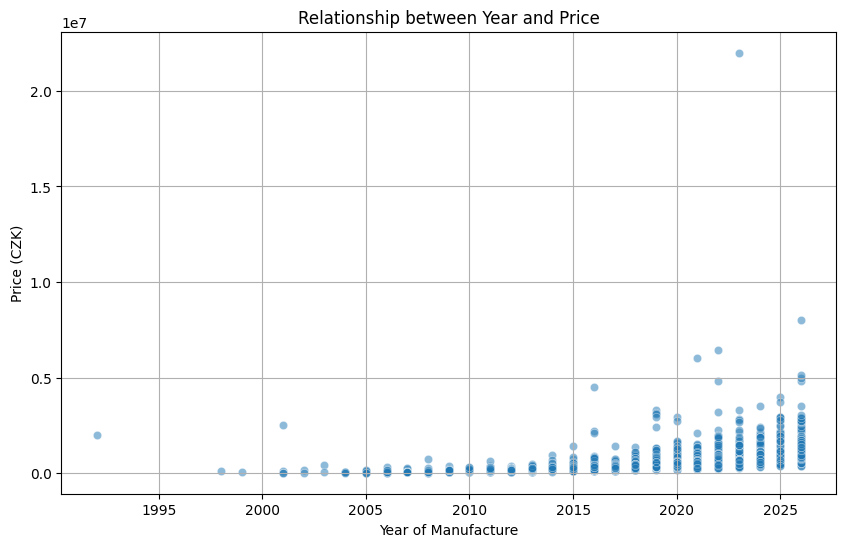

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='price', data=df_clean, alpha=0.5)
plt.title('Relationship between Year and Price')
plt.xlabel('Year of Manufacture')
plt.ylabel('Price (CZK)')
plt.grid(True)
plt.show()

6. Data Preparation: One-Hot Encoding

Machine learning algorithms require numerical input. We use One-Hot Encoding to convert categorical variables (Brand, Fuel, Transmission) into binary columns (0 or 1).

In [6]:
# Select features for training
features = ['year', 'mileage', 'fuel', 'transmission', 'brand']
target = 'price'

# Create a subset with only relevant columns
X_raw = df_clean[features]
y = df_clean[target]

# One-Hot Encode categorical variables
X = pd.get_dummies(X_raw, columns=['fuel', 'transmission', 'brand'], drop_first=True)

print("Features shape:", X.shape)
X.head()

Features shape: (1970, 1935)


,year,mileage,fuel_Elektro,fuel_Hybridní,fuel_Nafta,fuel_Other,transmission_Manual,transmission_Manuální,brand_BMW,brand_Dacia,...,brand_https://www.sauto.cz/osobni/detail/volvo/xc90/209289570,brand_https://www.sauto.cz/osobni/detail/volvo/xc90/209416710,brand_https://www.sauto.cz/osobni/detail/volvo/xc90/209486565,brand_https://www.sauto.cz/osobni/detail/volvo/xc90/209542698,brand_https://www.sauto.cz/osobni/detail/volvo/xc90/209720340,brand_https://www.sauto.cz/osobni/detail/volvo/xc90/209720544,brand_https://www.sauto.cz/osobni/detail/volvo/xc90/209789751,brand_https://www.sauto.cz/osobni/detail/volvo/xc90/209855850,brand_https://www.sauto.cz/osobni/detail/volvo/xc90/209863038,brand_Škoda
0,2022.0,18455.0,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4,2020.0,146589.0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,2022.0,51653.0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
10,2023.0,40122.0,False,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
13,2019.0,158365.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


7. Model Training (Random Forest)

We split the data into training (80%) and testing (20%) sets. Then, we train a Random Forest Regressor. This model is chosen because it handles non-linear relationships well and is robust against outliers.

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model training completed.")

Model training completed.


8. Model Evaluation

We evaluate the model's performance using Mean Absolute Error (MAE), which tells us the average prediction error in CZK, and the R² Score, which indicates how well the model explains the variance in the data.

Mean Absolute Error: 225,851 CZK
R2 Score: 0.3138


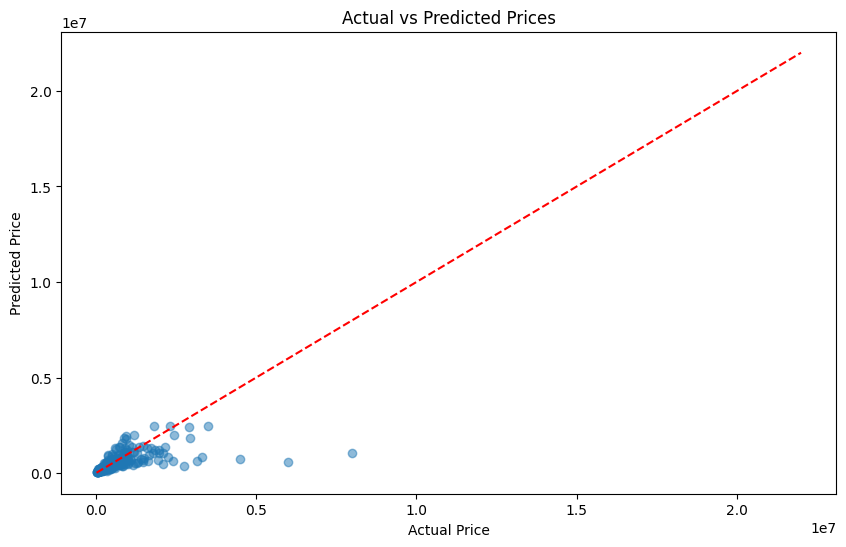

In [8]:
# Make predictions
predictions = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: {mae:,.0f} CZK")
print(f"R2 Score: {r2:.4f}")

# Visual comparison of Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--') # Perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()

9. Exporting Model and Data

Finally, we save the trained model and the list of feature columns. These files will be downloaded and used in our Desktop Application to make real-time predictions.

In [9]:
# Save the model
joblib.dump(model, 'car_price_model.pkl')

# Save the column names (needed to ensure input matches training data)
joblib.dump(X.columns, 'model_columns.pkl')

# Save processed data for reference
df_clean.to_csv('sauto_processed.csv', index=False)

print("Files saved: 'car_price_model.pkl', 'model_columns.pkl', 'sauto_processed.csv'")

Files saved: 'car_price_model.pkl', 'model_columns.pkl', 'sauto_processed.csv'
